In [2]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import joblib

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

### 开始预测新分子

In [64]:
rdkit_descriptors_df = pd.read_csv('./generate_and_pred_data/data/2.final_extend_data_rdkit_descriptors.csv')
rdkit_descriptors_df

,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW
0,1,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,2.308093,1.227435,1.227435,-0.000139,14.273950,1.474828
1,10,Brc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,3.838429,1.070255,1.070255,0.018137,79.918731,1.623463
2,100,Cc1ccc(C#Cc2c3ccccc3c(C#Cc3ccccc3)c3cc4ccccc4c...,3.533942,1.008111,1.008111,0.040654,14.143554,1.459498
3,1000,N#Cc1ccc(-c2c3ccccc3c(-c3ccc(I)cc3)c3ccccc23)cc1,9.173973,0.678583,0.678583,0.099110,126.912704,1.485139
4,1001,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3ccccc23)cc1C#N,9.539119,0.398424,0.398424,0.100532,14.279392,1.431312
...,...,...,...,...,...,...,...,...
9424,995,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3ccc(I)cc23)cc1,9.190427,0.678562,0.678562,0.099110,126.912704,1.485047
9425,996,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3cc(I)ccc23)cc1,9.184727,0.678533,0.678533,0.099110,126.912704,1.485079
9426,997,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(I)cccc23)cc1,9.190427,0.678562,0.678562,0.099110,126.912704,1.485066
9427,998,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3I)c3ccccc23)cc1,9.180301,0.678538,0.678538,0.099110,126.912704,1.485117


In [65]:
rdkit_descriptors_df[rdkit_descriptors_df['Filename']==7562]

,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW
7274,7562,N#Cc1cc2[nH]c1c(-c1ccccc1Cl)c1nc(c(-c3ccccc3Cl...,10.728434,0.45829,0.45829,0.101417,35.498976,1.026469


In [66]:
len(rdkit_descriptors_df)

9429

In [70]:
global_features_4_df = pd.read_csv('./generate_and_pred_data/data/5.global_features_4_32dim.csv')
global_features_4_df

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,Lifetime,Filename
0,0.000000,0.936550,0.000000,0.464482,1.301748,0.904289,0.414741,1.560330,0.769313,0.000000,...,0.000000,1.188992,0.413637,0.427432,1.435909,1.137159,0.257895,0.000000,0.0,1
1,1.796709,1.092806,2.289346,0.715530,1.037076,1.134038,0.650129,1.077527,1.116255,1.639229,...,0.000000,1.418584,0.544208,0.601894,0.000000,1.357842,0.000000,0.000000,0.0,2
2,0.427798,1.403304,0.000000,1.008717,0.837205,1.324594,0.937103,0.735777,1.421208,1.942213,...,0.552600,1.643320,0.736550,0.782549,0.000000,1.565382,0.000000,0.000000,0.0,3
3,0.490679,1.080870,0.406215,0.731753,0.849793,1.122761,0.662984,0.872763,1.099937,1.341709,...,0.000000,1.423904,0.563560,0.606461,0.124880,1.362636,0.000000,0.000000,0.0,4
4,1.838331,0.936394,1.176238,0.538071,0.869415,0.986999,0.482117,0.487201,1.002804,2.594984,...,0.000000,1.269169,0.395166,0.501203,0.000000,1.225103,0.000000,0.000000,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9272,2.880133,4.467715,0.074634,4.218792,3.908837,4.555895,4.023911,2.314058,4.598728,5.908135,...,0.000000,4.259500,2.947879,2.748431,0.301821,3.972168,0.000000,0.000000,0.0,9443
9273,0.000000,0.000000,0.058619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.901796,0.108603,0.000000,0.000000,0.000000,0.154457,0.736009,0.404250,0.0,9444
9274,2.365877,1.127266,0.297706,0.649520,0.680525,1.025471,0.600706,0.089586,1.212457,3.690925,...,0.000000,1.358406,0.434998,0.584505,0.000000,1.310206,0.000000,0.000000,0.0,9445
9275,0.467072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.927903,...,0.422587,0.156477,0.000000,0.000000,0.000000,0.204903,0.000000,0.343126,0.0,9446


In [68]:
global_features_4_df[global_features_4_df['Filename']==7562]

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,Lifetime,Filename
7413,0.0,0.068861,0.0,0.0,0.080053,0.01976,0.0,0.618127,0.0,0.0,...,0.078873,0.516702,0.0,0.0,0.396282,0.524842,0.859239,0.006706,0.0,7562


In [69]:
len(global_features_4_df)

9277

In [151]:
# 合并feature_conv2_df和df_lifetime两个DataFrame
merged_rdkit_global_features = pd.merge(rdkit_descriptors_df, global_features_4_df, on='Filename', how='inner')
# 显示合并后的DataFrame的前几行以确认更改
merged_rdkit_global_features.head()

,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW,1,2,...,24,25,26,27,28,29,30,31,32,Lifetime
0,1,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,2.308093,1.227435,1.227435,-0.000139,14.273950,1.474828,0.000000,0.936550,...,0.000000,0.000000,1.188992,0.413637,0.427432,1.435909,1.137159,0.257895,0.000000,0.0
1,10,Brc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,3.838429,1.070255,1.070255,0.018137,79.918731,1.623463,0.000000,0.437092,...,0.277496,0.333498,0.805473,0.062630,0.140878,0.699696,0.788371,0.547740,0.000000,0.0
2,100,Cc1ccc(C#Cc2c3ccccc3c(C#Cc3ccccc3)c3cc4ccccc4c...,3.533942,1.008111,1.008111,0.040654,14.143554,1.459498,0.000000,0.603134,...,0.000000,0.458213,0.930892,0.174160,0.234692,0.915830,0.902318,0.554415,0.000000,0.0
3,1000,N#Cc1ccc(-c2c3ccccc3c(-c3ccc(I)cc3)c3ccccc23)cc1,9.173973,0.678583,0.678583,0.099110,126.912704,1.485139,1.115197,0.000000,...,0.802669,0.000000,0.042894,0.000000,0.000000,0.000000,0.095711,0.000000,0.477373,0.0
4,1001,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3ccccc23)cc1C#N,9.539119,0.398424,0.398424,0.100532,14.279392,1.431312,0.593804,1.614420,...,1.984964,0.000000,1.856802,0.957447,0.922517,1.129716,1.754468,0.000000,0.000000,0.0


In [152]:
Ir_Expand_df = pd.read_csv('generate_and_pred_data/data//IrSpecInfo_Expand.csv')
Ir_Expand_df.head()

,Filename,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
0,1,0.409144,0.425184,0.446610,0.474279,0.509353,0.553415,0.608511,0.677054,0.761440,...,0.021745,0.021694,0.021643,0.021593,0.021543,0.021492,0.021442,0.021393,0.021343,0.021294
1,10,1.358258,1.265642,1.199540,1.155034,1.128280,1.117433,1.123473,1.149654,1.200132,...,0.017641,0.017601,0.017561,0.017521,0.017481,0.017441,0.017402,0.017362,0.017323,0.017284
2,100,0.703589,0.739739,0.766095,0.775200,0.757657,0.712867,0.651671,0.587965,0.531020,...,0.018143,0.018102,0.018061,0.018020,0.017979,0.017939,0.017899,0.017858,0.017818,0.017779
3,1000,3.421195,2.956977,2.605284,2.353692,2.188354,2.098645,2.078545,2.126797,2.246567,...,0.008753,0.008735,0.008716,0.008698,0.008680,0.008662,0.008644,0.008626,0.008608,0.008590
4,1001,0.300753,0.300674,0.304796,0.313266,0.326263,0.343664,0.364423,0.385805,0.403378,...,0.009591,0.009569,0.009547,0.009526,0.009504,0.009482,0.009461,0.009440,0.009418,0.009397


In [153]:
Ir_Expand_df[Ir_Expand_df['Filename']==7562]

,Filename,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
7147,7562,2.691764,2.827291,3.017195,3.27247,3.603058,4.010664,4.474365,4.932484,5.281571,...,0.034467,0.034382,0.034298,0.034213,0.03413,0.034046,0.033964,0.033881,0.0338,0.033718


In [154]:
# 合并merged_df_fc和ir_df两个DataFrame
final_merged_df = pd.merge(merged_rdkit_global_features, Ir_Expand_df, on='Filename', how='inner')
final_merged_df.head()

,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW,1,2,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
0,1,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,2.308093,1.227435,1.227435,-0.000139,14.273950,1.474828,0.000000,0.936550,...,0.021745,0.021694,0.021643,0.021593,0.021543,0.021492,0.021442,0.021393,0.021343,0.021294
1,10,Brc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,3.838429,1.070255,1.070255,0.018137,79.918731,1.623463,0.000000,0.437092,...,0.017641,0.017601,0.017561,0.017521,0.017481,0.017441,0.017402,0.017362,0.017323,0.017284
2,100,Cc1ccc(C#Cc2c3ccccc3c(C#Cc3ccccc3)c3cc4ccccc4c...,3.533942,1.008111,1.008111,0.040654,14.143554,1.459498,0.000000,0.603134,...,0.018143,0.018102,0.018061,0.018020,0.017979,0.017939,0.017899,0.017858,0.017818,0.017779
3,1000,N#Cc1ccc(-c2c3ccccc3c(-c3ccc(I)cc3)c3ccccc23)cc1,9.173973,0.678583,0.678583,0.099110,126.912704,1.485139,1.115197,0.000000,...,0.008753,0.008735,0.008716,0.008698,0.008680,0.008662,0.008644,0.008626,0.008608,0.008590
4,1001,N#Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3ccccc23)cc1C#N,9.539119,0.398424,0.398424,0.100532,14.279392,1.431312,0.593804,1.614420,...,0.009591,0.009569,0.009547,0.009526,0.009504,0.009482,0.009461,0.009440,0.009418,0.009397


In [155]:
# final_merged_df['Filename']

In [176]:
X = final_merged_df.drop(['Filename','SMILES','Lifetime'], axis=1)  # 特征
# 加载保存的模型
loaded_model = joblib.load('data/random_forest_model-expand.joblib')

# 假设您有新的特征数据 X_new，可以直接使用 loaded_model 进行预测
Y_pred = loaded_model.predict(X)

In [179]:
# 创建新的 DataFrame
result_df = pd.DataFrame({'Filename': final_merged_df['Filename'],
    'Smiles': final_merged_df['SMILES'],'Predicted_Y': Y_pred})

# 按照 Predicted_Y 从大到小排序
result_df_sorted = result_df.sort_values(by='Predicted_Y', ascending=False).reset_index(drop=True)
result_df_sorted.head()

,Filename,Smiles,Predicted_Y
0,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,2.087426
1,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,1.994198
2,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,1.970305
3,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.931546
4,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.901708


获取文件名Filename对应的pro_from_smi1_name，需要从cleaned_all_products中获

In [158]:
cleaned_all_products = pd.read_csv('./cleaned_all_products.csv')
cleaned_all_products.head()

,index,smi1,smi2,product,pro_from_smi1_name,similarity
0,0,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,a1,0.888889
1,1,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c...,a1,0.888889
2,2,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccccc1-c1c2ccccc2c(-c2ccccc2)c2c(-c3ccccc3)...,a1,0.727273
3,6,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,a1,0.888889
4,7,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c4...,a1,0.888889


In [159]:
cleaned_all_products.index.name = 'real_filename'  # 将索引命名为'real_filename'
cleaned_all_products = cleaned_all_products.reset_index()  # 将索引转换为一列
cleaned_all_products['real_filename'] = cleaned_all_products['real_filename'] + 1
cleaned_all_products.iloc[7562:7576][:5]

,real_filename,index,smi1,smi2,product,pro_from_smi1_name,similarity
7562,7563,36553,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([n...,p114,0.962963
7563,7564,36554,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1cc(Cl)c(-c2c3nc(c(-c4c(Cl)cccc4Cl)c4ccc([nH...,p114,0.962963
7564,7565,36569,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,CBr,Cc1cc2[nH]c1c(-c1c(Cl)cccc1Cl)c1nc(c(-c3c(Cl)c...,p114,0.962963
7565,7566,36594,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,BrBr,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,p114,0.962963
7566,7567,36596,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,BrBr,Clc1cccc(Cl)c1-c1c2nc(c(-c3c(Cl)cccc3Cl)c3ccc(...,p114,0.962963


In [160]:
def contains_se(smiles):
    """
    检查SMILES字符串是否包含硒（Se）元素。

    Parameters:
    - smiles (str): 分子的SMILES字符串。

    Returns:
    - bool: 如果包含Se元素，返回True，否则返回False。
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return any(atom.GetSymbol() == 'Se' for atom in mol.GetAtoms())
    return False

# 记录包含Se元素的分子索引
se_indices = []
pro_smiles = cleaned_all_products['product'].values
index = cleaned_all_products.index
for idx, smiles in enumerate(pro_smiles):
    if contains_se(smiles):
        se_indices.append(idx) 

In [161]:
set(cleaned_all_products.iloc[se_indices]['pro_from_smi1_name'])

{'a189', 'a201', 'p39', 'p40'}

In [162]:
cleaned_all_pros_without_Se = cleaned_all_products.drop(index=se_indices, axis=0)
cleaned_all_pros_without_Se = cleaned_all_pros_without_Se.reset_index(drop=True)
# 创建 Filename 列，基于 DataFrame 的索引（从1开始）
cleaned_all_pros_without_Se['Filename'] = cleaned_all_pros_without_Se.index + 1
cleaned_all_pros_without_Se.iloc[7562:7576][:5]

,real_filename,index,smi1,smi2,product,pro_from_smi1_name,similarity,Filename
7562,7643,37833,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,CBr,Cc1cc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=O)(=O)O)c4...,p119,0.982456,7563
7563,7644,37834,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,CBr,Cc1cc(S(=O)(=O)O)c(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(...,p119,0.982456,7564
7564,7645,37848,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,CBr,Cc1cc2[nH]c1c(-c1c(Cl)ccc(S(=O)(=O)O)c1Cl)c1nc...,p119,0.982456,7565
7565,7646,37874,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,BrBr,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,p119,0.982456,7566
7566,7647,37876,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,BrBr,O=S(=O)(O)c1ccc(Cl)c(-c2c3nc(c(-c4c(Cl)ccc(S(=...,p119,0.982456,7567


In [163]:
# cleaned_all_pros_without_Se[cleaned_all_pros_without_Se['pro_from_smi1_name']=='p114']

In [164]:
# 选择需要的列
cleaned_subset = cleaned_all_pros_without_Se[
    ['real_filename','Filename', 'product', 'pro_from_smi1_name']].copy()
cleaned_subset.head()

,real_filename,Filename,product,pro_from_smi1_name
0,1,1,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,a1
1,2,2,Cc1cccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c...,a1
2,3,3,Cc1ccccc1-c1c2ccccc2c(-c2ccccc2)c2c(-c3ccccc3)...,a1
3,4,4,Cc1cccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,a1
4,5,5,Cc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c4...,a1


In [165]:
# cleaned_subset[cleaned_subset['pro_from_smi1_name']=='p114']

In [188]:
# 确保 Filename 列的数据类型一致
result_df_sorted['Filename'] = result_df_sorted['Filename'].astype(int)
result_df_sorted_2['Filename'] = result_df_sorted_2['Filename'].astype(int)
cleaned_subset['Filename'] = cleaned_subset['Filename'].astype(int)

In [190]:
# 合并 DataFrame，基于 Filename
result_df_extended_2 = result_df_sorted_2.merge(cleaned_subset, on='Filename', how='left')
result_df_extended_2.head()

,Filename,Smiles,Predicted_Y,real_filename,product,pro_from_smi1_name
0,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,2.241362,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,a12
1,4641,Cc1ccc(/C=C/C=C/c2ccccc2)cc1,2.056325,4641,Cc1ccc(/C=C/C=C/c2ccccc2)cc1,a168
2,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.940032,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,a54
3,932,Cc1c2ccccc2c(-c2ccccc2)c2ccccc12,1.938176,932,Cc1c2ccccc2c(-c2ccccc2)c2ccccc12,a32
4,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.925911,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,a32


In [191]:
# 合并 DataFrame，基于 Filename
result_df_extended = result_df_sorted.merge(cleaned_subset, on='Filename', how='left')
result_df_extended.head()

,Filename,Smiles,Predicted_Y,real_filename,product,pro_from_smi1_name
0,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,2.087426,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,a32
1,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,1.994198,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,a32
2,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,1.970305,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,a12
3,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.931546,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,a32
4,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.901708,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,a54


In [183]:
# result_df_extended[(result_df_extended['Filename'] >= 7562) & (result_df_extended['Filename'] <= 7576)][:5]

In [169]:
# 检查是否有未匹配的行
missing = result_df_extended[result_df_extended['product'].isna() | result_df_extended['pro_from_smi1_name'].isna()]
if not missing.empty:
    print("警告：以下 Filename 在 cleaned_all_products_without_Se 中未找到匹配项：")
    print(missing)
else:
    print("所有 Filename 都成功匹配。")

所有 Filename 都成功匹配。


In [193]:
# 确保 'Predicted_Y' 列的数据类型为浮点数
result_df_extended['Predicted_Y'] = result_df_extended['Predicted_Y'].astype(float)
# 计算 Real_Y
result_df_extended['Initial_Y'] = np.power(10, result_df_extended['Predicted_Y'])
result_df_extended.head()

,Filename,Smiles,Predicted_Y,real_filename,product,pro_from_smi1_name,Initial_Y
0,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,2.087426,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,a32,122.299958
1,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,1.994198,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,a32,98.672921
2,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,1.970305,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,a12,93.391069
3,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.931546,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,a32,85.417256
4,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.901708,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,a54,79.745842


In [222]:
# 确保 'Predicted_Y' 列的数据类型为浮点数
result_df_extended_2['Predicted_Y'] = result_df_extended_2['Predicted_Y'].astype(float)
# 计算 Real_Y
result_df_extended_2['Initial_Y'] = np.power(10, result_df_extended_2['Predicted_Y'])
result_df_extended_2.head()

,Smiles,Predicted_Y,real_filename,product,pro_from_smi1_name,Initial_Y
Filename,,,,,,
324,Cc1cc2ccc3cccc4ccc(c1)c2c34,2.241362,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,a12,174.325782
4641,Cc1ccc(/C=C/C=C/c2ccccc2)cc1,2.056325,4641,Cc1ccc(/C=C/C=C/c2ccccc2)cc1,a168,113.847938
1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.940032,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,a54,87.102756
932,Cc1c2ccccc2c(-c2ccccc2)c2ccccc12,1.938176,932,Cc1c2ccccc2c(-c2ccccc2)c2ccccc12,a32,86.731417
931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.925911,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,a32,84.316197


In [171]:
# 检查 'Real_Y' 中是否存在无限大或接近零的值
infinite_real_Y = result_df_extended[np.isinf(result_df_extended['Initial_Y'])]
near_zero_real_Y = result_df_extended[result_df_extended['Initial_Y'] < 1e-10]

print(f"存在 {len(infinite_real_Y)} 个无限大的 Initial_Y 值。")
print(f"存在 {len(near_zero_real_Y)} 个接近零的 Initial_Y 值。")

存在 0 个无限大的 Initial_Y 值。
存在 0 个接近零的 Initial_Y 值。


In [172]:
# 保存扩展后的 DataFrame 到新的 CSV 文件（可选）
result_df_extended.to_csv('predicted_results_sorted_extended.csv', index=False)

In [195]:
# 保存扩展后的 DataFrame 到新的 CSV 文件（可选）
result_df_extended.to_csv('predicted_results_sorted_extended_2.csv', index=False)

### 读取理论预测结果

1. generate_and_pred_data/1.generate_smiles/miss_smi1_in_pro_smi记录了没有生成smiles的12个原始分子: p1,p8,p9,p10,p15,p33,p53,p74,p75,p77,p151,p217
2. generate_and_pred_data/2.generate_gjf/cleaned_all_pros_without_Se中未包含含有Se元素的2ge 原始分子：p39,p40; 在生成cleaned_all_products_without_Se时删除了80行含有Se元素的分子，因此原来的9527行变成了9447行，然后再生成3D构象和坐标文件时，设置了：indices = range(1, len(cleaned_all_products_without_Se) + 1)，即文件名为1-9447
3. 对生成的gjf文件，进行Gaussian优化时，得到9277个normal的log文件
6. predicted_results_sorted_extended.csv中的Filename为log文件名，index为0-9446.
7. cleaned_all_products_without_Se.csv的索引（非index）+1为predicted_results_sorted_extended.csv的Filename，二者有些差异，cleaned_all_products_without_Se.csv中index对应的pro_from_smi1_name是正确的，predicted_results_sorted_extended.csv中的pro_from_smi1_name是错误的，如何进行修改
8. cleaned_all_products_without_Se.csv的索引(非index)对应的product等正确，predicted_results_sorted_extended.csv中Filename对应的product正确，只需要按照cleaned_all_products_without_Se.csv的索引（非index）对应pro_pro_from_smi1_name,将predicted_results_sorted_extended.csv中pro_pro_from_smi1_name替换掉即可。
9. 'cleaned_all_products_without_Se'中有‘p114’，但是predicted_results_sorted_extended.csv没有，这是因为在normal——logs中没有，Gaussian优化没有成功

In [93]:
pr_df = pd.read_csv('generate_and_pred_data/predicted_results_sorted_extended.csv')
print(pr_df.shape),
pr_df[pr_df['pro_from_smi1_name']=='p114']
pr_df.head()

(9277, 6)


,Filename,Smiles,Predicted_Y,product,pro_from_smi1_name,Initial_Y
0,929,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,2.087426,Cc1ccc2cc3ccccc3c(-c3ccccc3)c2c1,a32,122.299958
1,926,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,1.994198,Cc1cccc(-c2c3ccccc3cc3ccccc23)c1,a32,98.672921
2,324,Cc1cc2ccc3cccc4ccc(c1)c2c34,1.970305,Cc1cc2ccc3cccc4ccc(c1)c2c34,a12,93.391069
3,931,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,1.931546,Cc1cccc2c(-c3ccccc3)c3ccccc3cc12,a32,85.417256
4,1769,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,1.901708,Cc1ccc2cc3ccc4cc5ccccc5c5ccc(c2c1)c3c45,a54,79.745842


In [95]:
cleaned_all_products_without_Se = pd.read_csv('generate_and_pred_data/2.generate_gjf/cleaned_all_products_without_Se.csv') # 这个时纠正index后的csv
cleaned_all_products_without_Se[cleaned_all_products_without_Se['pro_from_smi1_name']=='p114']
cleaned_all_products_without_Se.head()

,index,smi1,smi2,product,pro_from_smi1_name,similarity
0,0,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4...,a1,0.888889
1,1,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c...,a1,0.888889
2,2,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccccc1-c1c2ccccc2c(-c2ccccc2)c2c(-c3ccccc3)...,a1,0.727273
3,6,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1cccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c...,a1,0.888889
4,7,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,CBr,Cc1ccc2c(-c3ccccc3)c3c(-c4ccccc4)c4ccccc4c(-c4...,a1,0.888889


检查cleaned_all_products_without_Se.csv的索引(非index)对应的product，与predicted_results_sorted_extended.csv中Filename对应的product一样即可(经验证，确实对应)

In [106]:
cleaned_all_products_without_Se.iloc[4675:4676, :]

,index,smi1,smi2,product,pro_from_smi1_name,similarity
4675,21248,C(/C=C/C=C/c1ccccc1)=C\C=C\c1ccccc1,ClCl,Clc1cccc(/C=C/C=C/C=C/C=C/c2ccccc2)c1,a171,0.6


In [105]:
pr_df[pr_df['Filename']==4675+1]

,Filename,Smiles,Predicted_Y,product,pro_from_smi1_name,Initial_Y
1919,4676,Clc1cccc(/C=C/C=C/C=C/C=C/c2ccccc2)c1,-0.428789,Clc1cccc(/C=C/C=C/C=C/C=C/c2ccccc2)c1,a171,0.372573


根据cleaned_all_products_without_Se.csv中索引与pro_from_smi1_name的正确对照，替换pr_df中不正确的pro_from_smi1_name

In [122]:
# 创建映射：cleaned_df.index+1 = predicted_df["Filename"]
mapping = {i+1: name for i, name in zip(cleaned_all_products_without_Se.index, 
                                        cleaned_all_products_without_Se["pro_from_smi1_name"])}
# mapping

In [123]:
# 复制一份用于比较
predicted_df_corrected = pr_df.copy()
# 替换 pro_from_smi1_name
predicted_df_corrected["pro_from_smi1_name"] = predicted_df_corrected["Filename"].map(mapping)

In [124]:
# 找到不一致的条目
diff_df = pr_df[pr_df["pro_from_smi1_name"] != predicted_df_corrected["pro_from_smi1_name"]].copy()
diff_df # 说明原来的predicted_results_sorted_extended.csv中的pro_from_smi1_name是正确的

,Filename,Smiles,Predicted_Y,product,pro_from_smi1_name,Initial_Y


In [125]:
diff_df["corrected_pro_from_smi1_name"] = predicted_df_corrected.loc[diff_df.index, "pro_from_smi1_name"]
diff_df

,Filename,Smiles,Predicted_Y,product,pro_from_smi1_name,Initial_Y,corrected_pro_from_smi1_name


#### 拆分ps和acceptor

In [129]:
pr_df_cleaned = pr_df.drop(columns=['Smiles'])
pr_df_cleaned_a = pr_df_cleaned[pr_df_cleaned['pro_from_smi1_name'].str.startswith('a')].copy()
pr_df_cleaned_p = pr_df_cleaned[pr_df_cleaned['pro_from_smi1_name'].str.startswith('p')].copy()

In [130]:
pr_df_cleaned_a_sorted = pr_df_cleaned_a.sort_values(by='Predicted_Y', ascending=False).reset_index(drop=True)
# pr_df_cleaned_a_sorted.head()

In [128]:
pr_df_cleaned_p_sorted = pr_df_cleaned_p.sort_values(by='Predicted_Y', ascending=False).reset_index(drop=True)
pr_df_cleaned_p_sorted.head()

,Filename,Predicted_Y,product,pro_from_smi1_name,Initial_Y
0,9248,0.660247,Cc1cc(C)c2[nH]c3c(C)c(C)c(C)cc3c2c1,p243,4.573482
1,6103,0.640328,CC1=CC(C)=[N+]2C1=C(c1ccc3c4cccc5c(C)ccc(c6ccc...,p45,4.368456
2,6102,0.595029,CC1=CC(C)=[N+]2C1=C(c1ccc3c4ccc(C)c5cccc(c6ccc...,p45,3.935761
3,7036,0.554666,Cc1c2nc(c3ccc(ccc4nc(cc5ccc1[nH]5)C=C4)[nH]3)C=C2,p87,3.586463
4,7160,0.534861,Cc1ccc(C2=Cc3nc2ccc2[nH]c(cc2-c2ccccc2)c2nc(cc...,p94,3.426585


观察重要性

In [103]:
# X = merged_df_fc_ir_32.drop(['lifetime', 'Filename','Lifetime'], axis=1)  # 特征
# y = merged_df_fc_ir_32['lifetime']     
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
# model_ = RandomForestRegressor(n_estimators=240, max_depth=5, random_state=1)  # 60 0.6675942410613139
# model_.fit(X_train, y_train)
# # 对测试集进行预测
# y_pred = model_.predict(X_test)

# # 评估模型性能
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"R^2 Score: {r2}")
# print(f"mse Score: {mse}")

In [114]:
importances = model_.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

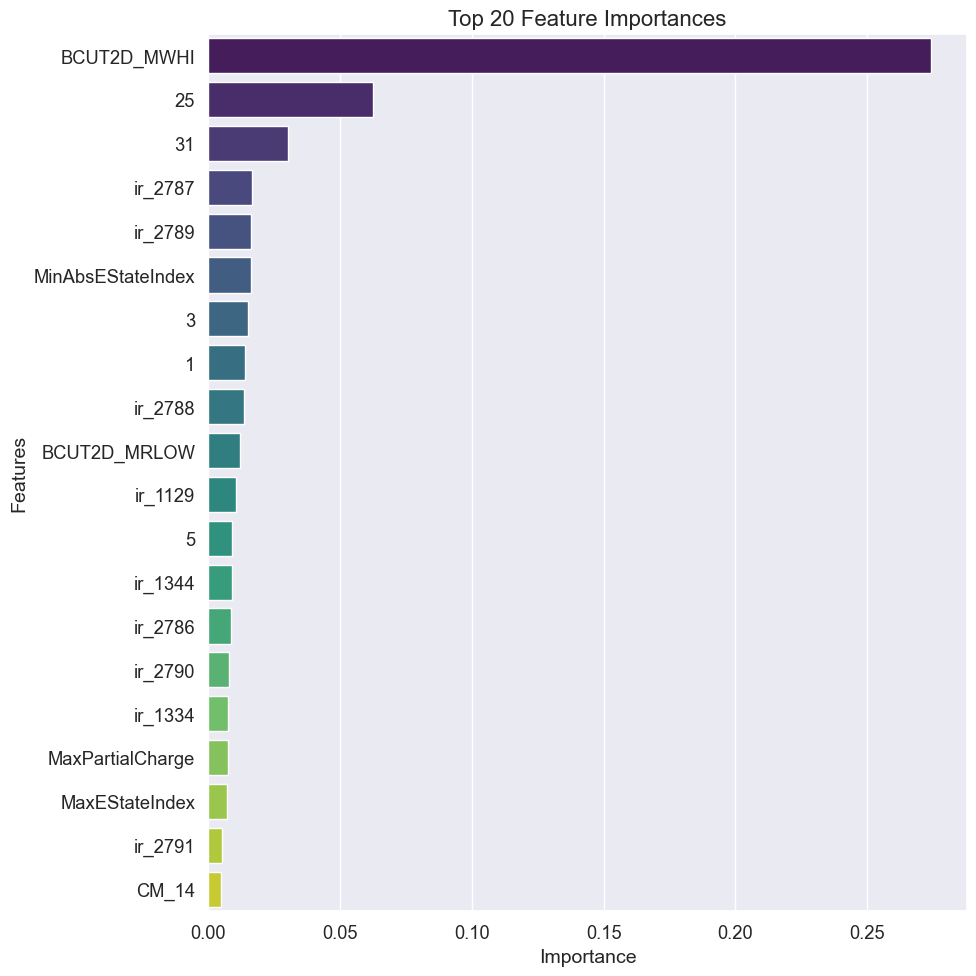

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 feature_importances 已经是一个排序好的 Pandas Series：
# feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# 假设 feature_importances 是已经排好序的Series
# 如果特征过多，可以只取前30个举例
top_n = 20
feature_importances_top = feature_importances.iloc[:top_n]

plt.figure(figsize=(10, 0.5 * len(feature_importances_top)))  # 高度根据特征数自动调整
sns.set_style("whitegrid")
sns.set(font_scale=1.2)  # 调整字体大小

sns.barplot(x=feature_importances_top.values, 
            y=feature_importances_top.index, 
            palette="viridis")

plt.title("Top {} Feature Importances".format(top_n), fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

# 调整边距，避免标签被遮挡
plt.subplots_adjust(left=0.3)

plt.tight_layout()
plt.show()

In [128]:
# 设置一个阈值，比如：保留特征重要性大于0.01的特征
threshold = 0.005

# 根据阈值选择特征
selected_features = feature_importances[feature_importances > threshold].index
selected_features, len(selected_features)

(Index(['BCUT2D_MWHI', '25', '31', 'ir_2787', 'ir_2789', 'MinAbsEStateIndex',
        '3', '1', 'ir_2788', 'BCUT2D_MRLOW', 'ir_1129', '5', 'ir_1344',
        'ir_2786', 'ir_2790', 'ir_1334', 'MaxPartialCharge', 'MaxEStateIndex',
        'ir_2791'],
       dtype='object'),
 19)

In [129]:
X_selected = X[selected_features]

In [130]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=37)
model_ = RandomForestRegressor(n_estimators=240, max_depth=5, random_state=1)  # 60 0.6675942410613139
model_.fit(X_train, y_train)
# 对测试集进行预测
y_pred = model_.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")  # 3/0.7579  4/0.7531458069979966
print(f"mse Score: {mse}")

R^2 Score: 0.7922949631126751
mse Score: 0.6310116142669655


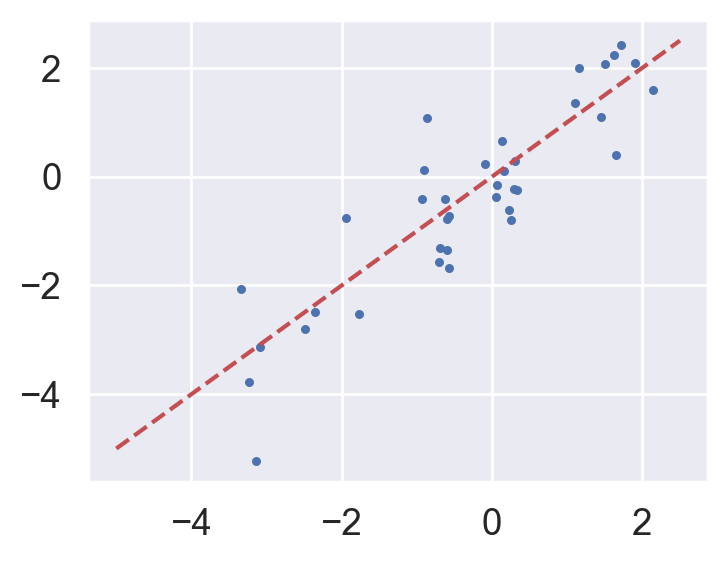

In [131]:
figsize = (4,3)
plt.figure(1, figsize=figsize, dpi=200)
plt.scatter(y_pred, y_test, s=5)
plt.plot([-5, 2.5], [-5, 2.5], "r--")
# plt.axis([min(y_pred)-10,80, min(y_test)-10, 80])
plt.show()

#### 尝试不降维，选择其他机器学习方法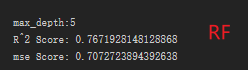

In [135]:
from xgboost import XGBRegressor
X = merged_df_fc_ir_32.drop(['lifetime', 'Filename','Lifetime'], axis=1)  # 特征
y = merged_df_fc_ir_32['lifetime']               # 目标变量
# n_estimators_list = [50,100,150,200,250,300]
# n_estimators_list = [30,40,50,60,70,80]
# for n in n_estimators_list:
#     print(f"n_estimators:{n}")
depth = [3,4,5,]
for n in depth:
    print(f"max_depth:{n}")
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
    model_xgb = XGBRegressor(
        n_estimators=40,
        max_depth=n,
        learning_rate=0.1,
        random_state=37
    )
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)

    r2_xgb = r2_score(y_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    print(f"XGBoost R^2: {r2_xgb}, MSE: {mse_xgb}")

max_depth:3
XGBoost R^2: 0.7271243495712623, MSE: 0.8290011029659997
max_depth:4
XGBoost R^2: 0.7637106250104775, MSE: 0.7178513442943366
max_depth:5
XGBoost R^2: 0.7336677127756139, MSE: 0.8091222486050778


In [145]:
from catboost import CatBoostRegressor
X = merged_df_fc_ir_32.drop(['lifetime', 'Filename','Lifetime'], axis=1)  # 特征
y = merged_df_fc_ir_32['lifetime']               # 目标变量
# n_estimators_list = [50,80,90,100,110,120,130,]
# n_estimators_list = [30,40,50,60,70,80,90]
# for n in n_estimators_list:
#     print(f"n_estimators:{n}")
depth = [3,4,5,]
for n in depth:
    print(f"max_depth:{n}")
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
    model_cat = CatBoostRegressor(
    iterations=80,
    depth=n,
    learning_rate=0.1,
    random_state=37,
    verbose=0)
    model_cat.fit(X_train, y_train)
    y_pred_cat = model_cat.predict(X_test)

    r2_cat = r2_score(y_test, y_pred_cat)
    mse_cat = mean_squared_error(y_test, y_pred_cat)
    print(f"CatBoost R^2: {r2_cat}, MSE: {mse_cat}")

max_depth:3
CatBoost R^2: 0.7370172960100974, MSE: 0.7989461548733714
max_depth:4
CatBoost R^2: 0.713040760137374, MSE: 0.8717872993747654
max_depth:5
CatBoost R^2: 0.6263355403473636, MSE: 1.1351993067337707


In [156]:
from sklearn.neural_network import MLPRegressor
X = merged_df_fc_ir_32.drop(['lifetime', 'Filename','Lifetime'], axis=1)  # 特征
y = merged_df_fc_ir_32['lifetime']               # 目标变量
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
model_mlp = MLPRegressor(
hidden_layer_sizes=(256,128),
# hidden_layer_sizes=(128,128,64),
activation='relu',
solver='adam',
alpha=0.0001,
learning_rate_init=0.001,
max_iter=500,
random_state=1
)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)

r2_mlp = r2_score(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"MLP R^2: {r2_mlp}, MSE: {mse_mlp}")

MLP R^2: 0.489390029808794, MSE: 1.551242215305286


In [161]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1,1, 10,20,50, 80,100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.5,0.6,0.8,0.9,1]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, scoring='r2', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
y_pred_svr = best_svr.predict(X_test)

r2_svr = r2_score(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Best SVR params: {grid_search.best_params_}")
print(f"SVR R^2: {r2_svr}, MSE: {mse_svr}")

Best SVR params: {'C': 10, 'epsilon': 0.9, 'gamma': 'scale'}
SVR R^2: 0.6323903160428013, MSE: 1.1168047899571982


张百成测试

In [1]:
from rdkit.Chem import AllChem, Draw
rt_sma = "[c:1].[C:2]>>[c:1][C:2]"
rt = AllChem.ReactionFromSmarts(rt_sma)

smi1 = "C=Cc1cc2cc3nc(c4c5[nH]c(cc6nc(cc1[nH]2)C(C)=C6)cc5C(=O)C4)CC3"
smi2 = "C"
mol1 = AllChem.MolFromSmiles(smi1)
mol2 = AllChem.MolFromSmiles(smi2)

products = rt.RunReactants((mol1, mol2))

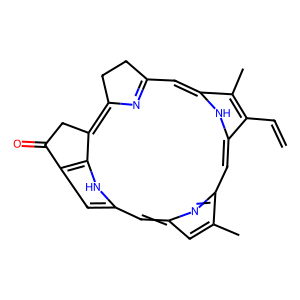

In [153]:
Draw.MolToImage(products[1][0])

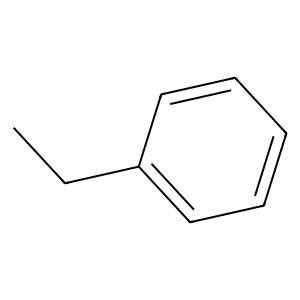

In [146]:
new_smi = "c1c(C)cccc1"
Draw.MolToImage(AllChem.MolFromSmiles(new_smi))

In [5]:
smiles_199 = 'n1onc2c1cc3c(non3)c2'
smiles_200 = 'n1nnc2c1cc3c(nnn3)c2'
mol_199 = AllChem.MolFromSmiles(smiles_199)
Draw.MolToImage(mol_199)

[13:52:20] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 10 11


ValueError: Null molecule provided

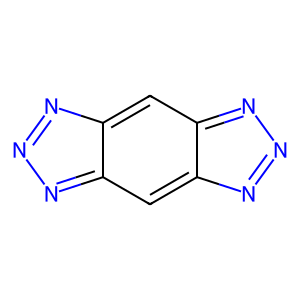

In [6]:
mol_200 = AllChem.MolFromSmiles(smiles_200)
Draw.MolToImage(mol_200)